<a href="https://colab.research.google.com/github/Vibha111094/Time_Series/blob/main/Forecast_Volume_For_Staffing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Indian Restaurant datatset: https://www.kaggle.com/henslersoftware/19560-indian-takeaway-orders

Objective: forecast out order volume for staffing

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

In [2]:
!pip3 install pandasql

  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26781 sha256=c81386d4e37b5f9d6905f7397235b700236a37e27ac9fde0db176fad3944b1a5
  Stored in directory: /root/.cache/pip/wheels/5c/4b/ec/41f4e116c8053c3654e2c2a47c62b4fca34cc67ef7b55deb7f
Successfully built pandasql


In [3]:
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

In [7]:
orders = pd.read_csv('/content/restaurant-1-orders.csv')
orders.columns = ['number', 'timestamp', 'item', 'quantity', 'price', 'total_products_in_cart']

In [9]:
orders.sample(2)

,number,timestamp,item,quantity,price,total_products_in_cart
17493,14109,31/03/2019 17:53,Peshwari Naan,2,2.95,6
65588,2121,19/03/2016 20:21,Korma,1,8.95,9


In [10]:
orders['date'] = pd.to_datetime(orders['timestamp'].str[:10])

In [11]:
print(f"Total number of orders in dataset: {orders['number'].nunique()}")

Total number of orders in dataset: 13397


In [12]:
def load_query(path):
    with open(path) as file:
        return file.read()

Case 1: Direct Multistep Forecasting

In [15]:
query = load_query('/content/queries/daily_orders.sql')

In [16]:
daily_orders = pysqldf(query)

In [17]:
daily_orders

,date,num_orders
0,2015-01-09,1
1,2015-01-10,7
2,2015-02-10,5
3,2015-08-09,3
4,2015-09-09,6
...,...,...
1202,2019-12-03,11
1203,2019-12-04,25
1204,2019-12-05,23
1205,2019-12-06,9


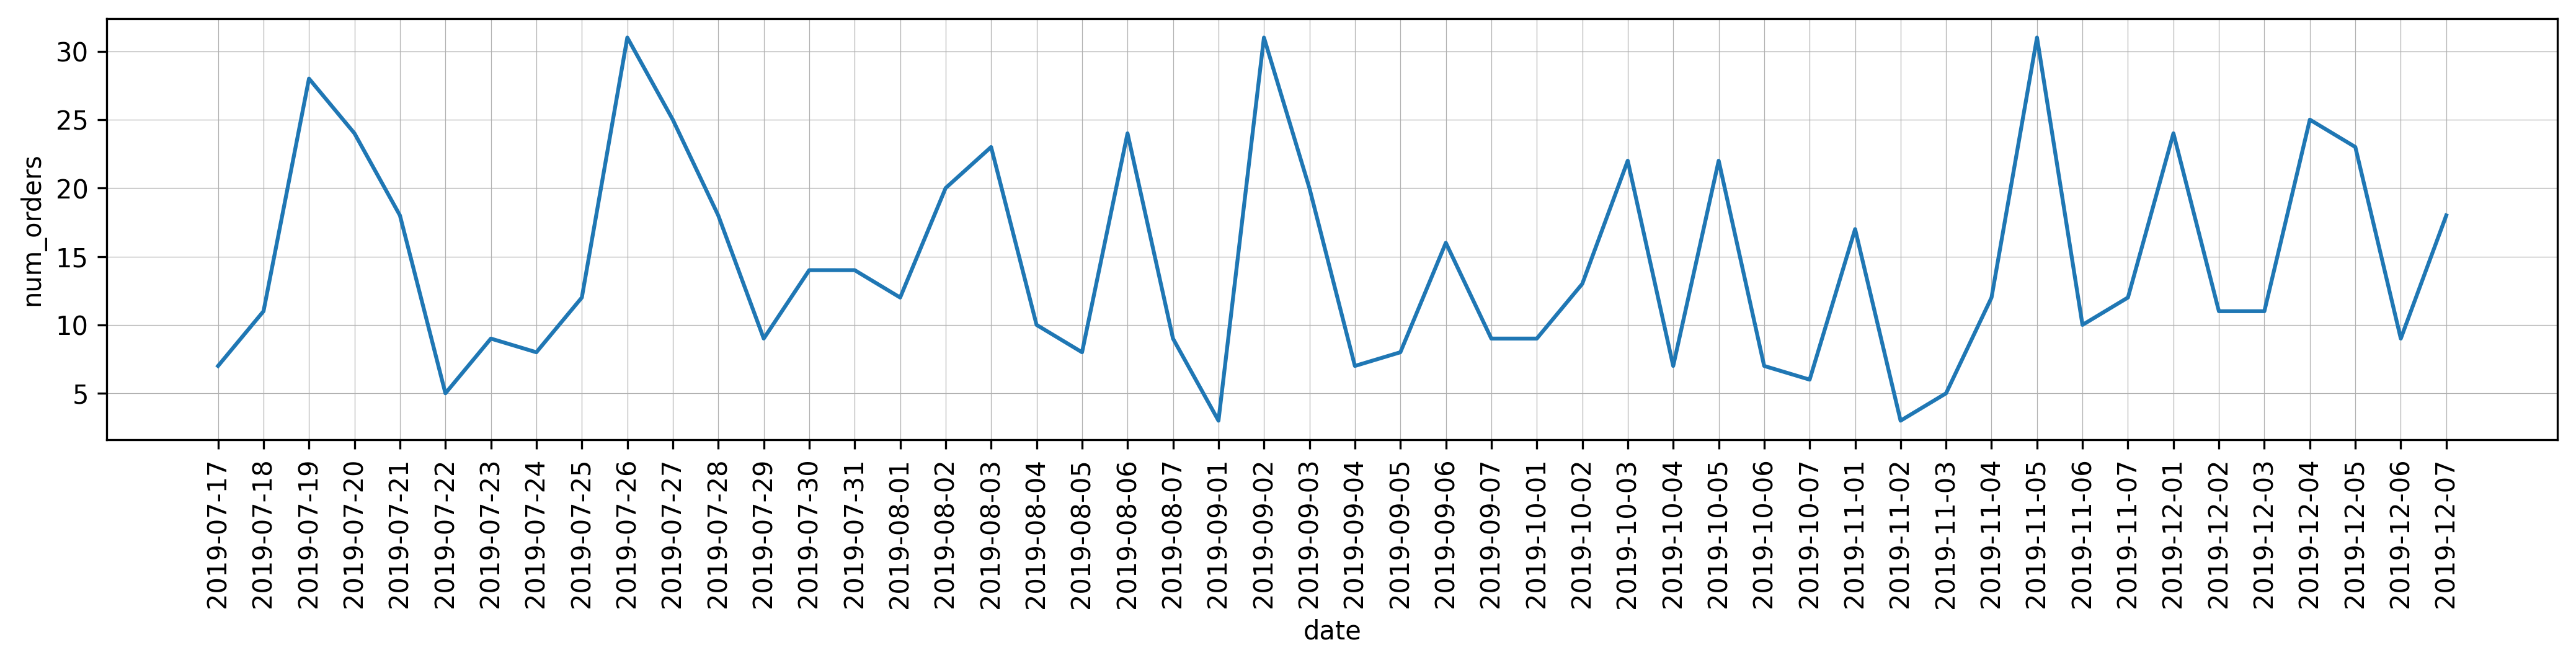

In [18]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=daily_orders.tail(50), x='date', y='num_orders')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

In [19]:
query = load_query('/content/queries/weekly_orders.sql')
weekly_orders = pysqldf(query)

In [20]:
weekly_orders

,week,num_orders
0,2015-01-05,8
1,2015-02-09,5
2,2015-08-03,3
3,2015-09-07,6
4,2015-09-28,7
...,...,...
191,2019-10-07,6
192,2019-10-28,25
193,2019-11-04,65
194,2019-11-25,24


In [21]:
weekly_orders.sample(2)

,week,num_orders
36,2016-09-12,57
32,2016-08-15,48


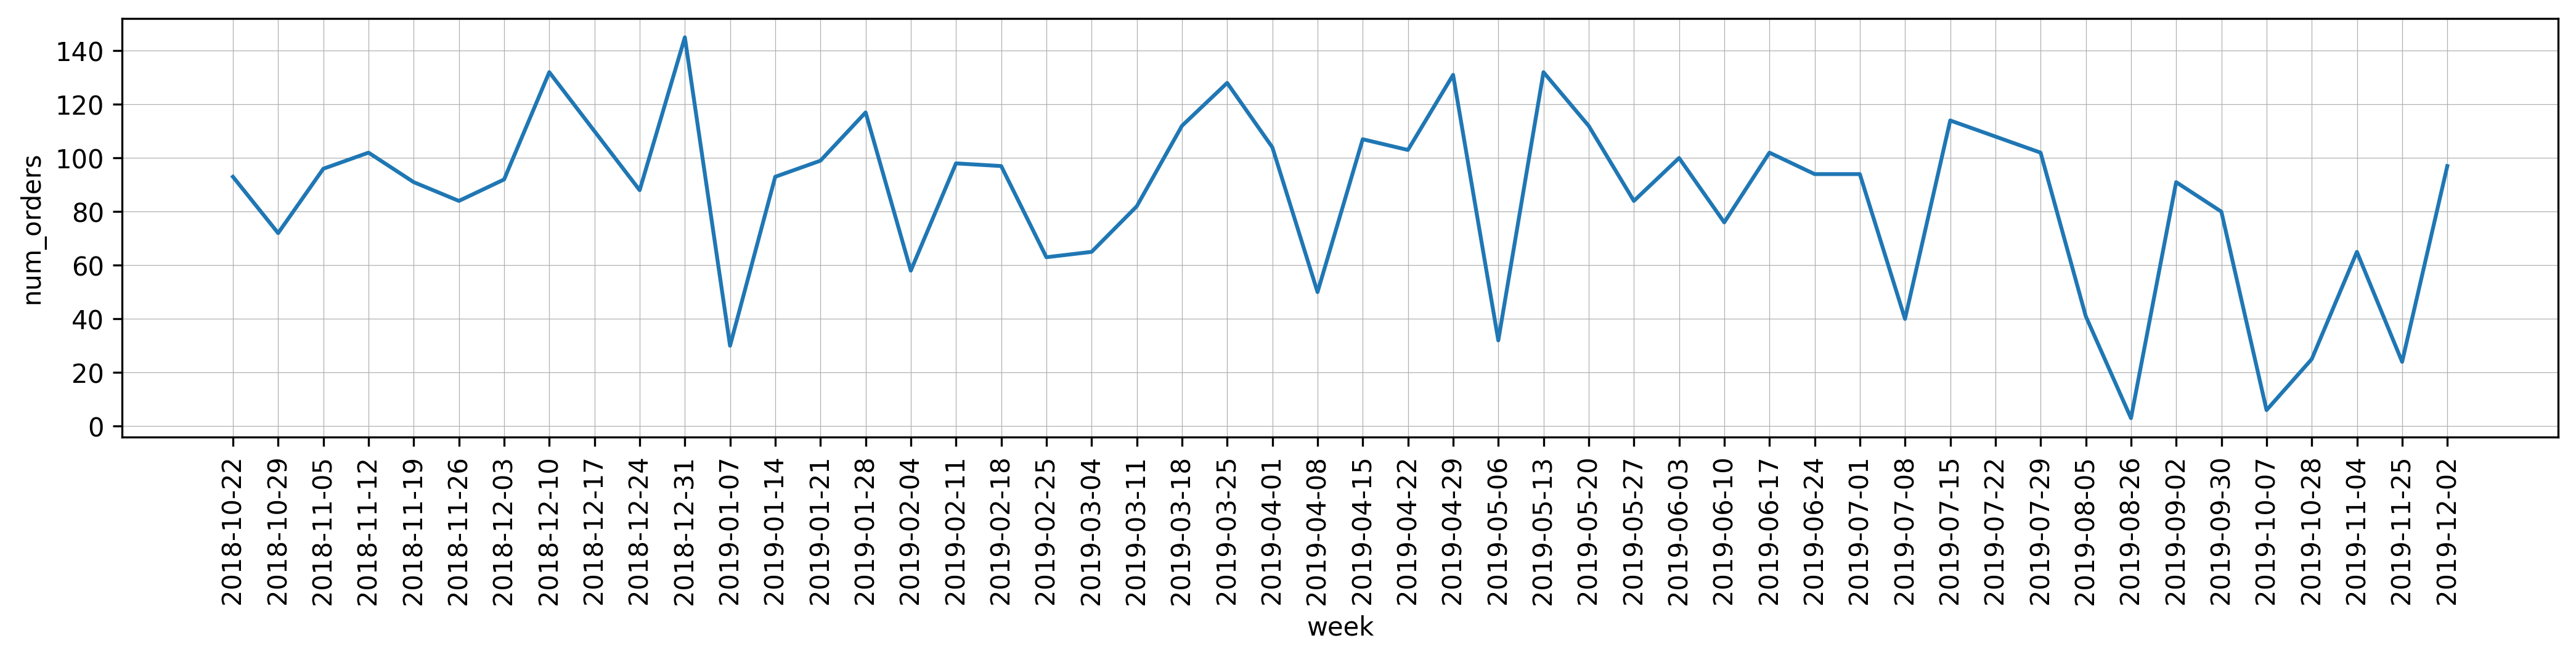

In [22]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=weekly_orders.tail(50), x='week', y='num_orders')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

In [23]:
query = load_query('/content/queries/base.sql')
df = pysqldf(query)
df.to_csv('/content/csvs/dataset.csv')

In [24]:
df.sample(3)

,week,order_count_7_day,order_count_30_day,label
62,2017-04-17,88,316,73
141,2018-10-22,100,438,93
134,2018-09-03,88,398,74


In [25]:
features = ['order_count_7_day', 'order_count_30_day']
label = 'label'
test_df = df[df['week'] >= '2019-06-01']
train_df = df[df['week'] < '2019-06-01']
X_train, y_train = train_df[features], train_df[label]
X_test, y_test = test_df[features], test_df[label]

In [26]:
reg = XGBRegressor(n_estimators=500, learning_rate=0.01)
reg.fit(X_train, 
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='mae')

[16:40:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:68.7982	validation_1-mae:72.7346
[1]	validation_0-mae:68.1263	validation_1-mae:72.1123
[2]	validation_0-mae:67.4606	validation_1-mae:71.4771
[3]	validation_0-mae:66.8018	validation_1-mae:70.8668
[4]	validation_0-mae:66.1495	validation_1-mae:70.2625
[5]	validation_0-mae:65.5032	validation_1-mae:69.6457
[6]	validation_0-mae:64.8634	validation_1-mae:69.053
[7]	validation_0-mae:64.23	validation_1-mae:68.4662
[8]	validation_0-mae:63.6025	validation_1-mae:67.9042
[9]	validation_0-mae:62.9813	validation_1-mae:67.3468
[10]	validation_0-mae:62.3664	validation_1-mae:66.7949
[11]	validation_0-mae:61.7571	validation_1-mae:66.2685
[12]	validation_0-mae:61.154	validation_1-mae:65.7273
[13]	validation_0-mae:60.5568	validation_1-mae:65.1914
[14]	validation_0-mae:59.9652	validation_1-mae:64.6802
[15]	validation_0-mae:59.3796	validation_1-mae:64.1548
[16]	va

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [27]:
predictions = reg.predict(X_test)

In [28]:
test_df = test_df.reset_index().drop('index', axis=1)
test_df['predictions'] = pd.Series(predictions)

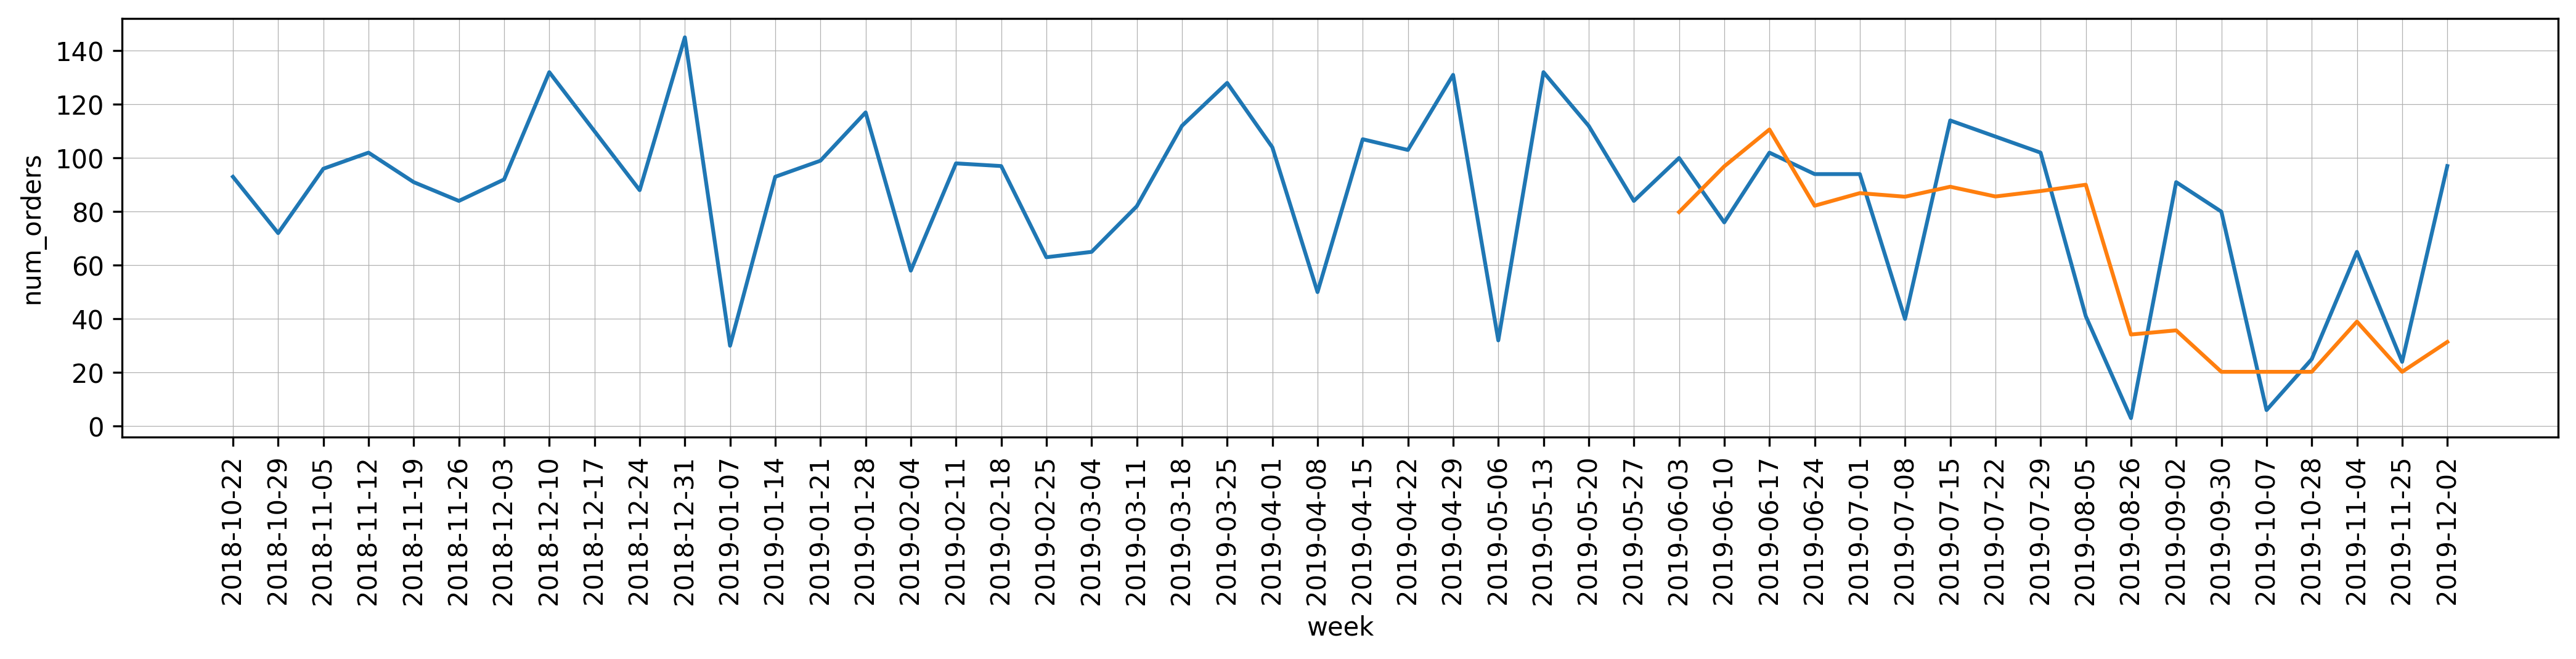

In [29]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=weekly_orders.tail(50), x='week', y='num_orders')
sns.lineplot(data=test_df, x='week', y='predictions')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

In [30]:
test_df

,week,order_count_7_day,order_count_30_day,label,predictions
0,2019-06-03,84,416,100,79.849602
1,2019-06-10,100,428,76,96.885750
2,2019-06-17,76,433,102,110.632874
3,2019-06-24,102,414,94,82.207954
4,2019-07-01,94,389,94,86.905693
5,2019-07-08,94,366,40,85.569130
6,2019-07-15,40,377,114,89.289177
7,2019-07-22,114,381,108,85.654594
8,2019-07-29,108,393,102,87.677574
9,2019-08-05,102,406,41,90.037697


Case 2: Prophet

In [41]:
from fbprophet import Prophet

In [42]:
data = df[['week', 'label']]
data.columns = ['ds', 'y']
train_df_prophet = data[data['ds'] < '2019-06-01']
test_df_prophet = data[data['ds'] >= '2019-06-01']

In [43]:
train_df_prophet

,ds,y
0,2016-01-04,40
1,2016-01-11,17
2,2016-02-01,26
3,2016-02-08,42
4,2016-02-29,15
...,...,...
168,2019-04-29,131
169,2019-05-06,32
170,2019-05-13,132
171,2019-05-20,112


In [34]:
data = df[['week', 'label']]
data.columns = ['ds', 'y']

In [35]:
data.sample(2)

,ds,y
43,2016-12-05,44
55,2017-02-27,38


In [44]:
res = []
for idx in range(173, 190):
    train_df_prophet = data[data.index < idx]
    test_df_prophet = data[data.index == idx]
    m = Prophet(weekly_seasonality=False, daily_seasonality=False)
    m.fit(train_df_prophet)
    prophet_predictions = m.predict(test_df_prophet)
    prophet_predictions['ds'] = prophet_predictions['ds'].apply(lambda x: x.strftime('%Y-%m-%d'))
    result = test_df_prophet.merge(prophet_predictions[['ds', 'yhat']], on='ds')
    res.append(result)

In [46]:
test_df_prophet = pd.concat(res)

In [47]:
test_df_prophet

,ds,y,yhat
0,2019-06-03,100,103.363586
0,2019-06-10,76,99.411225
0,2019-06-17,102,95.722115
0,2019-06-24,94,100.465272
0,2019-07-01,94,103.595351
0,2019-07-08,40,104.757820
0,2019-07-15,114,98.245419
0,2019-07-22,108,104.063933
0,2019-07-29,102,106.934977
0,2019-08-05,41,105.651890
